# CLIP Interrogator 2 by [@pharmapsychotic](https://twitter.com/pharmapsychotic) 

<br>

Want to figure out what a good prompt might be to create new images like an existing one? The CLIP Interrogator is here to get you answers!

<br>

This version is specialized for producing nice prompts for use with Stable Diffusion and achieves higher alignment between generated text prompt and source image. You can try out the old [version 1](https://colab.research.google.com/github/pharmapsychotic/clip-interrogator/blob/v1/clip_interrogator.ipynb) to see how different CLIP models ranks terms. 

<br>

If this notebook is helpful to you please consider buying me a coffee via [ko-fi](https://ko-fi.com/pharmapsychotic) or following me on [twitter](https://twitter.com/pharmapsychotic) for more cool Ai stuff. 🙂

And if you're looking for more Ai art tools check out my [Ai generative art tools list](https://pharmapsychotic.com/tools.html).


In [1]:
#@title Check GPU
!nvidia-smi -L

GPU 0: NVIDIA TITAN X (Pascal) (UUID: GPU-66d323e3-d032-af5e-c79c-899b8aebeed4)
GPU 1: NVIDIA GeForce RTX 2080 Ti (UUID: GPU-7aa8a3a7-a784-b012-bb27-8fb0a44d4698)


In [6]:
#@title Setup
import argparse, subprocess, sys, time

def setup():
    install_cmds = [
        ['pip', 'install', 'ftfy', 'regex', 'tqdm', 'transformers==4.21.2', 'timm', 'fairscale', 'requests'],
        ['pip', 'install', '-e', 'git+https://github.com/openai/CLIP.git@main#egg=clip'],
        ['pip', 'install', '-e', 'git+https://github.com/pharmapsychotic/BLIP.git@main#egg=blip'],
        ['git', 'clone', 'https://github.com/pharmapsychotic/clip-interrogator.git']
    ]
    for cmd in install_cmds:
        print(subprocess.run(cmd, stdout=subprocess.PIPE).stdout.decode('utf-8'))

# setup()

import sys
sys.path.append('/home/rob/persyn/interaction/notebooks/clip-interrogator/src/blip')
sys.path.append('/home/rob/persyn/interaction/notebooks/clip-interrogator/src/clip')

import clip
import hashlib
import io
import IPython
import ipywidgets as widgets
import math
import numpy as np
import os
import pickle
import requests
import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

from models.blip import blip_decoder
from PIL import Image
from torch import nn
from torch.nn import functional as F
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
from tqdm import tqdm
from zipfile import ZipFile


chunk_size = 2048
flavor_intermediate_count = 2048

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Loading BLIP model...")
blip_image_eval_size = 384
blip_model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth'        
blip_model = blip_decoder(pretrained=blip_model_url, image_size=blip_image_eval_size, vit='large', med_config='/home/rob/persyn/interaction/notebooks/clip-interrogator/src/blip/configs/med_config.json')
blip_model.eval()
blip_model = blip_model.to(device)

print("Loading CLIP model...")
clip_model_name = 'ViT-L/14' #@param ['ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px', 'RN101', 'RN50', 'RN50x4', 'RN50x16', 'RN50x64'] {type:'string'}
clip_model, clip_preprocess = clip.load(clip_model_name, device="cuda")
clip_model.cuda().eval()


class LabelTable():
    def __init__(self, labels, desc):
        self.labels = labels
        self.embeds = []

        hash = hashlib.sha256(",".join(labels).encode()).hexdigest()

        os.makedirs('./cache', exist_ok=True)
        cache_filepath = f"./cache/{desc}.pkl"
        if desc is not None and os.path.exists(cache_filepath):
            with open(cache_filepath, 'rb') as f:
                data = pickle.load(f)
                if data.get('hash') == hash and data.get('model') == clip_model_name:
                    self.labels = data['labels']
                    self.embeds = data['embeds']

        if len(self.labels) != len(self.embeds):
            self.embeds = []
            chunks = np.array_split(self.labels, max(1, len(self.labels)/chunk_size))
            for chunk in tqdm(chunks, desc=f"Preprocessing {desc}" if desc else None):
                text_tokens = clip.tokenize(chunk).cuda()
                with torch.no_grad():
                    text_features = clip_model.encode_text(text_tokens).float()
                text_features /= text_features.norm(dim=-1, keepdim=True)
                text_features = text_features.half().cpu().numpy()
                for i in range(text_features.shape[0]):
                    self.embeds.append(text_features[i])

            with open(cache_filepath, 'wb') as f:
                pickle.dump({"labels":self.labels, "embeds":self.embeds, "hash":hash, "model":clip_model_name}, f)
    
    def _rank(self, image_features, text_embeds, top_count=1):
        top_count = min(top_count, len(text_embeds))
        similarity = torch.zeros((1, len(text_embeds))).to(device)
        text_embeds = torch.stack([torch.from_numpy(t) for t in text_embeds]).float().to(device)
        for i in range(image_features.shape[0]):
            similarity += (image_features[i].unsqueeze(0) @ text_embeds.T).softmax(dim=-1)
        _, top_labels = similarity.cpu().topk(top_count, dim=-1)
        return [top_labels[0][i].numpy() for i in range(top_count)]

    def rank(self, image_features, top_count=1):
        if len(self.labels) <= chunk_size:
            tops = self._rank(image_features, self.embeds, top_count=top_count)
            return [self.labels[i] for i in tops]

        num_chunks = int(math.ceil(len(self.labels)/chunk_size))
        keep_per_chunk = int(chunk_size / num_chunks)

        top_labels, top_embeds = [], []
        for chunk_idx in tqdm(range(num_chunks)):
            start = chunk_idx*chunk_size
            stop = min(start+chunk_size, len(self.embeds))
            tops = self._rank(image_features, self.embeds[start:stop], top_count=keep_per_chunk)
            top_labels.extend([self.labels[start+i] for i in tops])
            top_embeds.extend([self.embeds[start+i] for i in tops])

        tops = self._rank(image_features, top_embeds, top_count=top_count)
        return [top_labels[i] for i in tops]

def generate_caption(pil_image):
    gpu_image = transforms.Compose([
        transforms.Resize((blip_image_eval_size, blip_image_eval_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])(pil_image).unsqueeze(0).to(device)

    with torch.no_grad():
        caption = blip_model.generate(gpu_image, sample=False, num_beams=3, max_length=20, min_length=5)
    return caption[0]

def rank_top(image_features, text_array):
    text_tokens = clip.tokenize([text for text in text_array]).cuda()
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

    similarity = torch.zeros((1, len(text_array)), device=device)
    for i in range(image_features.shape[0]):
        similarity += (image_features[i].unsqueeze(0) @ text_features.T).softmax(dim=-1)

    _, top_labels = similarity.cpu().topk(1, dim=-1)
    return text_array[top_labels[0][0].numpy()]

def similarity(image_features, text):
    text_tokens = clip.tokenize([text]).cuda()
    with torch.no_grad():
        text_features = clip_model.encode_text(text_tokens).float()       
    text_features /= text_features.norm(dim=-1, keepdim=True)
    similarity = text_features.cpu().numpy() @ image_features.cpu().numpy().T
    return similarity[0][0]

def load_list(filename):
    with open(filename, 'r', encoding='utf-8', errors='replace') as f:
        items = [line.strip() for line in f.readlines()]
    return items

def interrogate(image):
    caption = generate_caption(image)

    images = clip_preprocess(image).unsqueeze(0).cuda()
    with torch.no_grad():
        image_features = clip_model.encode_image(images).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

    flaves = flavors.rank(image_features, flavor_intermediate_count)
    best_medium = mediums.rank(image_features, 1)[0]
    best_artist = artists.rank(image_features, 1)[0]
    best_trending = trendings.rank(image_features, 1)[0]
    best_movement = movements.rank(image_features, 1)[0]

    best_prompt = caption
    best_sim = similarity(image_features, best_prompt)

    def check(addition):
        nonlocal best_prompt, best_sim
        prompt = best_prompt + ", " + addition
        sim = similarity(image_features, prompt)
        if sim > best_sim:
            best_sim = sim
            best_prompt = prompt
            return True
        return False

    def check_multi_batch(opts):
        nonlocal best_prompt, best_sim
        prompts = []
        for i in range(2**len(opts)):
            prompt = best_prompt
            for bit in range(len(opts)):
                if i & (1 << bit):
                    prompt += ", " + opts[bit]
            prompts.append(prompt)

        t = LabelTable(prompts, None)
        best_prompt = t.rank(image_features, 1)[0]
        best_sim = similarity(image_features, best_prompt)

    check_multi_batch([best_medium, best_artist, best_trending, best_movement])

    extended_flavors = set(flaves)
    for _ in tqdm(range(25), desc="Flavor chain"):
        try:
            best = rank_top(image_features, [f"{best_prompt}, {f}" for f in extended_flavors])
            flave = best[len(best_prompt)+2:]
            if not check(flave):
                break
            extended_flavors.remove(flave)
        except:
            # exceeded max prompt length
            break

    return best_prompt

DATA_PATH = '/home/rob/persyn/interaction/notebooks/clip-interrogator/data'

sites = ['Artstation', 'behance', 'cg society', 'cgsociety', 'deviantart', 'dribble', 'flickr', 'instagram', 'pexels', 'pinterest', 'pixabay', 'pixiv', 'polycount', 'reddit', 'shutterstock', 'tumblr', 'unsplash', 'zbrush central']
trending_list = [site for site in sites]
trending_list.extend(["trending on "+site for site in sites])
trending_list.extend(["featured on "+site for site in sites])
trending_list.extend([site+" contest winner" for site in sites])

raw_artists = load_list(f'{DATA_PATH}/artists.txt')
artists = [f"by {a}" for a in raw_artists]
artists.extend([f"inspired by {a}" for a in raw_artists])

artists = LabelTable(artists, "artists")
flavors = LabelTable(load_list(f'{DATA_PATH}/flavors.txt'), "flavors")
mediums = LabelTable(load_list(f'{DATA_PATH}/mediums.txt'), "mediums")
movements = LabelTable(load_list(f'{DATA_PATH}/movements.txt'), "movements")
trendings = LabelTable(trending_list, "trendings")



Loading BLIP model...
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_large_caption.pth
Loading CLIP model...


Preprocessing flavors: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 47/47 [00:54<00:00,  1.16s/it]


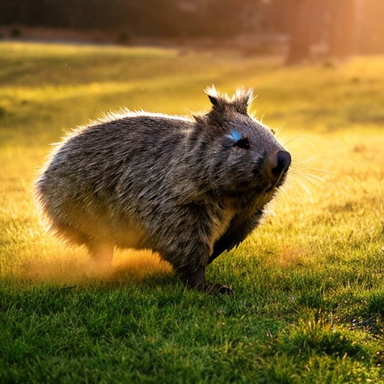

In [7]:
#@title Interrogate

#@markdown Run this cell and then paste a link to an image or upload an image in the UI. Then click the Interrogate button to get a prompt suggestion.

image_url = 'https://cdnb.artstation.com/p/assets/images/images/032/142/769/large/ignacio-bazan-lazcano-book-4-final.jpg'

def show_ui():
    go_button = widgets.Button(
        description='Interrogate!',
        disabled=False,
        button_style='',
        tooltip='Click me'
    )
    image_txt = widgets.Text(
        value=image_url, 
        description='', 
        layout=widgets.Layout(width='50%')
    )
    uploader = widgets.FileUpload(accept='image/*', multiple=False)

    ui = widgets.VBox([
        widgets.HBox([widgets.Label('image url:'), image_txt]),
        widgets.HBox([widgets.Label('or upload:'), uploader]),
        widgets.Label(''),
        go_button
    ])

    def go(btn):
        image_url = image_txt.value
        if len(uploader.value):
            print(uploader.value)
            print(uploader.value.items())
            for name, file_info in uploader.value.items():
                image = Image.open(io.BytesIO(file_info['content']))
                break
        else:
            if str(image_url).startswith('http://') or str(image_url).startswith('https://'):
                image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
            else:
                image = Image.open(image_url).convert('RGB')

        IPython.display.clear_output()
        print('\n\n')
        thumb = image.copy()
        thumb.thumbnail([blip_image_eval_size, blip_image_eval_size])
        print("Interrogating...")
        display(thumb)

        prompt = interrogate(image)
        IPython.display.clear_output()
        show_ui()

        print('\n\n')
        display(thumb)
        ui = widgets.VBox([
            widgets.Textarea(
                value=prompt,
                description='prompt:',
                layout=widgets.Layout(width='75%', height='6em')
            )
        ])
        display(ui)
    
    go_button.on_click(go)
    image_txt.on_submit(go)
    display(ui)

show_ui()